In [1]:
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
from itertools import groupby
from scipy.optimize import minimize

In [2]:
def find_knots(data, min_chain_length=8, verbose=False):
    mean = data[:,1].mean()
    lt = np.where(data[:,1]<mean)[0]
    
    chains = []
    for k, g in groupby(enumerate(lt), lambda ix: ix[0]-ix[1]):
        chain = list(map(itemgetter(1), g))
        if len(chain) > min_chain_length:
            chains.append(chain)
    if verbose:
        print(f'{len(chains)} chains found.')
    if len(chains) < 2:
        return np.array((-0.4, -0.1, 0.1, 0.4))
    elif len(chains) == 2:
        return np.sort((data[chains[0][0],0], data[chains[0][-1],0], data[chains[1][0],0], data[chains[1][-1],0]))
    else:
        lengths = np.array([len(chain) in chains])
        l = np.argsort(lengths)[::-1]
        return np.sort((data[chains[l[0]][0],0], data[chains[l[0]][-1],0], data[chains[l[1]][0],0], data[chains[l[1]][-1],0]))

In [3]:
def build_A_matrix(data, segs, knots):
    A = np.zeros(shape=(len(data),9))

    A[:segs[0],0] = data[:segs[0],0]**2
    A[segs[0]:,0] = knots[1]**2
    A[:segs[0],1] = data[:segs[0],0]
    A[segs[0]:,1] = knots[1]
    A[:,2] = 1.0

    for k in range(3):
        A[segs[k]:segs[k+1],3+2*k] = data[segs[k]:segs[k+1],0]**2-knots[k+1]**2
        A[segs[k]:segs[k+1],4+2*k] = data[segs[k]:segs[k+1],0]-knots[k+1]
        for j in range(k):
            A[segs[k]:segs[k+1],3+2*j] = knots[j+2]**2-knots[j+1]**2
            A[segs[k]:segs[k+1],4+2*j] = knots[j+2]-knots[j+1]
    
    return A

In [4]:
def polyfit(knots, data, min_pts_per_segment=5, return_ck=False):
    sdata = data.copy()
    sdata[:,0][sdata[:,0] < knots[0]] += 1
    sdata = sdata[sdata[:,0].argsort()]

    segs = [np.argmax(sdata[:,0]>knot) for knot in knots[1:]] + [len(sdata)]
    if np.ediff1d(segs).min() < min_pts_per_segment:
        return 1e10

    A = build_A_matrix(sdata, segs, knots)
    ck, ssr, rank, svd = np.linalg.lstsq(A, sdata[:,1], rcond=None)
    
    if return_ck:
        return ck, ssr
    return ssr

In [5]:
def coeffs(ck, knots, verbose=False):
    c0 = ck[2]
    c1 = (ck[0]-ck[3])*knots[1]**2 + (ck[1]-ck[4])*knots[1] + c0
    c2 = (ck[3]-ck[5])*knots[2]**2 + (ck[4]-ck[6])*knots[2] + c1
    c3 = (ck[5]-ck[7])*knots[3]**2 + (ck[6]-ck[8])*knots[3] + c2
    
    if verbose:
        print(f'segment 1:\n {knots[0]} < x <= {knots[1]}, a0={ck[0]} b0={ck[1]} c0={c0}')
        print(f'segment 2:\n {knots[1]} < x <= {knots[2]}, a0={ck[3]} b0={ck[4]} c0={c1}')
        print(f'segment 3:\n {knots[2]} < x <= {knots[3]}, a0={ck[5]} b0={ck[6]} c0={c2}')
        print(f'segment 4:\n {knots[3]} < x <= {knots[0]+1}, a0={ck[7]} b0={ck[8]} c0={c3}')
    
    return ((ck[0], ck[1], c0), (ck[3], ck[4], c1), (ck[5], ck[6], c2), (ck[7], ck[8], c3))

In [6]:
def extremes(coeffs, knots):
    exts = [-c[1]/2/c[0] for c in coeffs]
    knots = np.concatenate((knots, [knots[0]+1]))
    for k in range(4):
        if exts[k] < knots[k] or exts[k] > knots[k+1]:
            exts[k] = np.nan
    return np.array(exts)

In [7]:
def remap(d, xmin, xmax, sort=True):
    ncols = 1 if len(d.shape) == 1 else d.shape[1]
    x = d if ncols == 1 else d[:,0]

    while len(x[x<xmin]) > 0:
        x[x<xmin] += 1
    while len(x[x>xmax]) > 0:
        x[x>xmax] -= 1
    
    if sort and ncols > 1:
        d = d[d[:,0].argsort()]
    else:
        d.sort()

    return d

In [8]:
def fv(x, cks, knots, xmin=-0.5, xmax=0.5):
    x[x<knots[0]] += 1
    y = np.empty_like(x)
    for k in range(len(knots)-1):
        s = (x>=knots[k]) & (x<knots[k+1])
        y[s] = cks[k][0]*x[s]**2 + cks[k][1]*x[s] + cks[k][2]
    s = x>=knots[3]
    y[s] = cks[3][0]*x[s]**2 + cks[3][1]*x[s] + cks[3][2]
    
    return y

In [9]:
def plot(data, coeffs, knots, extremes, x=None, xmin=-0.5, xmax=0.5):
    if x is None:
        x = data[:,0]
    
    y = fv(x, coeffs, knots)
    d = np.vstack((x, y)).T
    
    remap(data, xmin, xmax)
    d = remap(d, xmin, xmax)
    remap(extremes, xmin, xmax)
    
    plt.plot(data[:,0], data[:,1], 'b.')
    plt.plot(d[:,0], d[:,1], 'r-')
    
    for k in range(4):
        plt.axvline(extremes[k], ls='--')
    plt.show()

In [10]:
def run_polyfit(data):
    sdata = data[data[:,0].argsort()]
    knots = find_knots(sdata)
    solution = minimize(polyfit, knots, args=(data,), method='Nelder-Mead')
    knots = solution.x
    ck, ssr = polyfit(knots, data, return_ck=True)
    final_coeffs = coeffs(ck, knots)
    final_extremes = extremes(final_coeffs, knots)
    return knots, final_coeffs, final_extremes, ssr

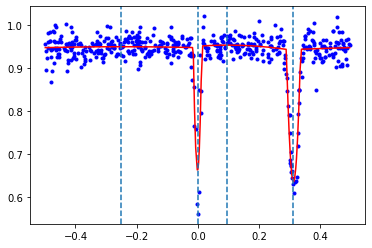

[0.3470799]


In [11]:
data = np.loadtxt('lc.dat')
knots, cks, exs, ssr = run_polyfit(data)
plot(data, cks, knots, exs)
print(ssr)